In [ ]:
cfrom google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/archive.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
len(os.listdir('/tmp/afhq/'))

2

1. Po pobraniu folderu plików jpeg, zostały one podzielone na 3 kategorie zawarte w folderze, a następnie przekształcone w format liczbowy (img_array) oraz ze zredykowaną ilością barw do 1 (GRAYSCALE) - zostało to wykonane w celu ograniczenia wielkości każdego z plików, który znacząco wpłynąłby na wydajność modelu.

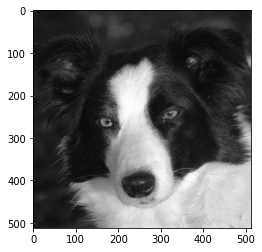

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2

DATADIR = '/tmp/afhq/train'
CATEGORIES = ['dog', 'cat', 'wild']

for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array, cmap = 'gray')
    plt.show()
    break
  break

In [ ]:
print(img_array)

[[ 26  26  26 ...  25  25  25]
 [ 26  26  26 ...  25  25  25]
 [ 26  26  26 ...  25  25  25]
 ...
 [ 25  25  24 ... 221 222 223]
 [ 22  22  22 ... 223 225 225]
 [ 20  20  20 ... 225 226 227]]


In [ ]:
print(img_array.shape)

(512, 512)


2. Zmniejszenie rozmiaru każdego ze zdjęć (format 64x64 okazał się najlepszy w wynikach późniejszego modelu)

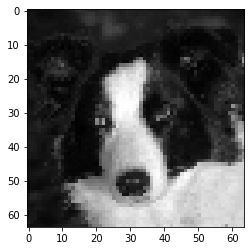

In [ ]:
IMG_SIZE = 64

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap = 'gray')
plt.show()

In [ ]:
data = []

def training():
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        data.append([new_array, class_num])
      except Exception as e:
        pass

training()

In [ ]:
print(len(data))

14630


3. Randomizacja sampli w celu poprawnego uczenia algorytmu klasyfikacji zdjęć

In [ ]:
import random

random.shuffle(data)

In [ ]:
for sample in data[:10]:
  print(sample[1])

0
0
0
0
0
2
2
0
2
0


In [ ]:
X = []
Y = []

In [ ]:
for item, label in data:
  X.append(item)
  Y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [ ]:
Y

array([0, 0, 0, ..., 2, 0, 0])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

4. Tworzenie modelu sieci neuronowej z wykorzystaniem KerasModels. Zastosowanie 5 warstw, z czego pierwsze 3 otrzymały powiększoną ilość połączeń, a ostatnie 2 pomniejszone oraz z pomocą funkcji Flatten() miały na celu zwiększenie poprawności wyniku wyjściwego. Zastosowane zostały metryki roc_auc oraz accuracy.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models


model = tf.keras.models.Sequential([
  tf.keras.layers.Input((64, 64, 1)),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size = (2,2)),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size = (2,2)),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size = (2,2)),
  
  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer='adam',
    loss = "categorical_crossentropy",
    metrics = [tf.keras.metrics.CategoricalAccuracy(name="acc"), tf.keras.metrics.AUC(name="auc")])
              

history = model.fit(X_train, Y_train,batch_size=16, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10
732/732 [==============================] - 7s 9ms/step - loss: 0.0000e+00 - acc: 1.0000 - auc: 0.5184 - val_loss: 0.0000e+00 - val_acc: 1.0000 - val_auc: 0.5273
Epoch 2/10
732/732 [==============================] - 6s 8ms/step - loss: 0.0000e+00 - acc: 1.0000 - auc: 0.5398 - val_loss: 0.0000e+00 - val_acc: 1.0000 - val_auc: 0.5200
Epoch 3/10
732/732 [==============================] - 6s 8ms/step - loss: 0.0000e+00 - acc: 1.0000 - auc: 0.5850 - val_loss: 0.0000e+00 - val_acc: 1.0000 - val_auc: 0.6656
Epoch 4/10
732/732 [==============================] - 6s 8ms/step - loss: 0.0000e+00 - acc: 1.0000 - auc: 0.6617 - val_loss: 0.0000e+00 - val_acc: 1.0000 - val_auc: 0.6896
Epoch 5/10
732/732 [==============================] - 6s 8ms/step - loss: 0.0000e+00 - acc: 1.0000 - auc: 0.6718 - val_loss: 0.0000e+00 - val_acc: 1.0000 - val_auc: 0.6316
Epoch 6/10
732/732 [==============================] - 6s 8ms/step - loss: 0.0000e+00 - acc: 1.0000 - auc: 0.6555 - val_loss: 0.0000e+00 - va

5. Graficzne przedstawienie procesu treningu modelu

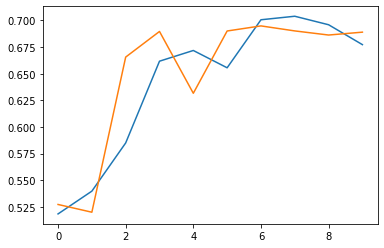

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["auc"])
plt.plot(history.history["val_auc"])
plt.show()

In [ ]:
Y_predicted = model.predict(X_test)

In [ ]:
Y_predicted

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

6. Confusion Matrix ukazujący wszystkie możliwe wariacje rzeczywistych i przewidywanych wyników modelu

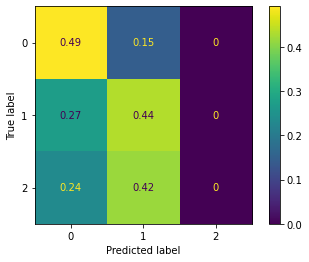

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = model.predict(X_train)

ConfusionMatrixDisplay.from_predictions(Y_train, tf.round(y_pred), normalize='pred')
plt.show()